## Download dataset

1. Go to your [Kaggle account](https://www.kaggle.com/settings), Scroll to API section and Click *Expire API Token* to remove previous tokens

2. Click on *Create New API Token* - It will download kaggle.json file on your machine.

3. Upload .json file here

In [ ]:
from google.colab import files
files.upload()

Download and unzip dataset

In [ ]:
!pip install -q kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

!rm -rf ./Data/

!unzip gtzan-dataset-music-genre-classification.zip "Data/genres_original/*/*"
!rm -rf ./gtzan* ./sample_data/ ./Data/genres_original/jazz/jazz.00054.wav

## Imports

In [ ]:
import os
import glob
import random

import time
from collections import Counter

import numpy as np
import librosa

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from IPython.display import Audio
from google.colab import files

## Work with songs
They are in ./Data/genres_original/{genre}/{genre}.000##.wav

In [ ]:
root = './Data/genres_original'

genres = [x for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]
genres

['disco',
 'hiphop',
 'jazz',
 'classical',
 'pop',
 'country',
 'metal',
 'blues',
 'rock',
 'reggae']

Listen to random song

In [ ]:
pattern = './Data/genres_original/*/*.wav'
file_paths = glob.glob(pattern)

random.shuffle(file_paths)

In [ ]:
song = file_paths[0]

print(song)

sample, sample_rate = librosa.load(song)

./Data/genres_original/metal/metal.00027.wav


In [ ]:
Audio(sample, rate=sample_rate)

In [ ]:
sample.shape

(661504,)

In [ ]:
sample_rate

22050

## Divide to train and test

In [ ]:
train_percent = 0.8

train = []
test = []

In [ ]:
genre_pattern = './Data/genres_original/'

for genre in genres:
  pat = './Data/genres_original/' + genre + "/*.wav"
  genre_files = glob.glob(pat)

  random.shuffle(genre_files)

  train_size = int(len(genre_files) * train_percent)

  train += genre_files[:train_size]
  test += genre_files[train_size:]

In [ ]:
random.shuffle(train)
random.shuffle(test)

In [ ]:
dict_train = {song: song.split('/')[3] for song in train}
dict_test = {song: song.split('/')[3] for song in test}

X_train, y_train = list(dict_train.keys()), list(dict_train.values())
X_test, y_test = list(dict_test.keys()), list(dict_test.values())

In [ ]:
len(X_train), len(X_test)

(799, 200)

## Hyperparameters

**Short-time Fourier transform (STFT).**

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

This function returns a complex-valued matrix D such that

np.abs(D[..., f, t]) is the magnitude of frequency bin f at frame t, and
np.angle(D[..., f, t]) is the phase of frequency bin f at frame t.
The integers t and f can be converted to physical units by means of the utility functions frames_to_samples and fft_frequencies.

**win_lengthint <= n_fft [scalar]**

Each frame of audio is windowed by window of length win_length and then padded with zeros to match n_fft. Padding is added on both the left- and the right-side of the window so that the window is centered within the frame.

Smaller values improve the temporal resolution of the STFT (i.e. the ability to discriminate impulses that are closely spaced in time) at the expense of frequency resolution (i.e. the ability to discriminate pure tones that are closely spaced in frequency). This effect is known as the time-frequency localization trade-off and needs to be adjusted according to the properties of the input signal y.

If unspecified, defaults to win_length = n_fft.

**hop_lengthint > 0 [scalar]**
number of audio samples between adjacent STFT columns.

Smaller values increase the number of columns in D without affecting the frequency resolution of the STFT.

If unspecified, defaults to win_length // 4

**На хлопський розум від Христі:**

n_fft - довжина вікна. 30 сек діляться на вікна такої довжини

hop_length - довжина стрибка. тобто якщо в тебе є вікно 512, а hop length 256, то ти спочатку рахуєм mfcc для вікна 0 - 512, потім зміщаєшся на 256 і вже рахуєш для 256 - 768

mfcc вертає матрицю n_mfcc x t, де t = len(sample)/hop_length, словом кількість вікон

щоб зрозуміти, як ті дані передані моделі, треба подивитися, як модельки з цим працюють.

In [ ]:
max_sample_length = 660000

n_fft = 22050 # length of the FFT window
hop_length = n_fft // 2 # number of samples between successive frames. See librosa.stft
n_mfcc = 128 # number of MFCCs to return

n_svd = 50

## Applying MFCC


In [ ]:
from numpy import fft

In [ ]:
songs = []

for i, song in enumerate(X_train):
  sample, sample_rate = librosa.load(song)
  sample = sample[:max_sample_length]

  sample = librosa.feature.mfcc(y=sample,
                                sr=sample_rate,
                                n_fft=n_fft,
                                hop_length=hop_length,
                                n_mfcc=n_mfcc)

  sample = sample.T

  songs.append(sample)

In [ ]:
songs = np.vstack(songs, dtype=np.float32)

In [ ]:
songs.shape

(47940, 128)

## Implementing SVD

In [ ]:
num_iterations = 1000

def power_iteration(A, num_iterations):
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_iterations):
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm

    eigenvalue = np.dot(np.dot(b_k, A), b_k) / np.dot(b_k, b_k)

    return b_k, eigenvalue

def calculate_eigenvectors(A, num_iterations, num_eigenvectors):
    eigenvectors = []
    eigenvalues = []

    for _ in range(num_eigenvectors):
        eigenvector, eigenvalue = power_iteration(A, num_iterations)
        eigenvectors.append(eigenvector)
        eigenvalues.append(eigenvalue)
        A = A - eigenvalue * np.outer(eigenvector, eigenvector)

    return eigenvalues, eigenvectors

def get_own_V_and_values(A):
  m = A.T @ A
  vals, eigenvectors = calculate_eigenvectors(m, num_iterations, m.shape[0])
  vals = np.float32(vals)
  eigenvectors = np.float32(eigenvectors)

  return eigenvectors[:, np.argsort(vals)[::-1]], np.sqrt(vals)

def get_own_singular_values(A):
    if (np.size(np.dot(A, A.T)) > np.size(np.dot(A.T, A))):
        newM = np.dot(A.T, A)
    else:
        newM = np.dot(A, A.T)

    eigenvalues, _ = calculate_eigenvectors(newM, num_iterations, newM.shape[0])
    eigenvalues = np.sqrt(np.abs(eigenvalues))

    return np.sort(eigenvalues)[::-1]

def own_svd(A):
  V, sv = get_own_V_and_values(A)
  U = A @ V / sv

  return U, sv, V.T

def own_truncate_svd(svd, n_svd):
  U, sv, VT = svd
  U_truncated = U[:, :n_svd]
  sv_truncated = sv[:n_svd]
  VT_truncated = VT[:n_svd, :]

  return U_truncated, sv_truncated, VT_truncated

## Visualization

In [ ]:
colors = {
    "blues": "blue",
    "classical": "green",
    "country": "red",
    "disco": "cyan",
    "hiphop": "magenta",
    "jazz": "yellow",
    "metal": "black",
    "pop": "olive",
    "reggae": "orange",
    "rock": "purple"
}

### Plotting 2D

In [ ]:
X_svd = own_svd(songs)

In [ ]:
X_svd_2, _, _ = own_truncate_svd(X_svd, 2)

In [ ]:
n_y_types = int(X_svd_2.shape[0] / len(X_train))
y_types = np.array([[colors[val]] * n_y_types for val in y_train]).flatten()

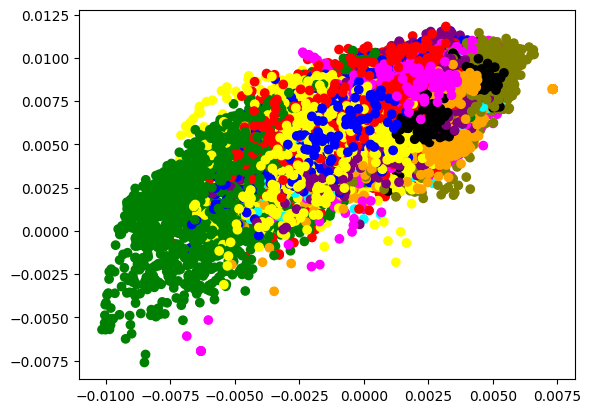

In [ ]:
plt.scatter(X_svd_2[:, 0], X_svd_2[:, 1], c=y_types)
plt.show()

### Plotting 3D

In [ ]:
X_svd_3, _, _ = own_truncate_svd(X_svd, 3)

In [ ]:
n_y_types = int(X_svd_3.shape[0] / len(X_train))
y_types = np.array([[colors[val]] * n_y_types for val in y_train]).flatten()

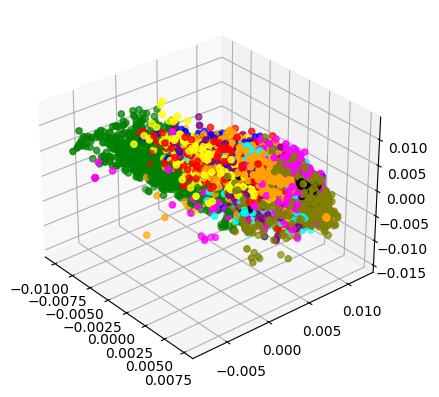

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_svd_3[:, 0], X_svd_3[:, 1], X_svd_3[:, 2], c=y_types)

ax.view_init(elev=30, azim=-40) # to change angle

plt.show()

## SVD

In [ ]:
U, S, V_T = own_truncate_svd(X_svd, n_svd)

In [ ]:
print(S)

print()
print(V_T.shape)

[41932.55    18841.764    6944.115    5346.366    3638.924    2991.7593
  2689.8413   2551.5437   2516.547    2443.1978   2377.4868   2281.4385
  2260.961    2198.988    2154.1133   2138.6836   1878.9249   1853.1583
  1829.9622   1799.143    1773.9623   1689.0388   1580.3442   1559.5397
  1459.0834   1436.9916   1356.4166   1350.8911   1273.4707   1268.3195
  1251.7323   1215.3816   1199.3309   1180.8875   1146.4199   1131.8378
  1105.6765   1102.9939   1073.029    1064.7811   1045.4869   1029.2317
  1020.836    1014.3284    967.0921    954.84375   946.6305    923.856
   905.5037    888.0795 ]

(50, 128)


In [ ]:
print(f"U : {U.shape}")
print(f"V^T : {V_T.shape}")

U : (47940, 50)
V^T : (50, 128)


In [ ]:
n_y_types = int(U.shape[0] / len(X_train))

In [ ]:
y_types = np.array([[val] * n_y_types for val in y_train]).flatten()

## SVM

In [ ]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(U, y_types)

print("--- %s seconds ---" % (time.time() - start_time))

--- 97.56772136688232 seconds ---


In [ ]:
def predict_class(prediction):
   label_counts = Counter(prediction)
   label, count  = label_counts.most_common(1)[0]
   return label

Testing model on test dataset

In [ ]:
total_observations = len(y_test)
true_predicted = 0
predictions = []

for i, song in enumerate(X_test):
  genre = y_test[i]

  sample, sample_rate = librosa.load(song)
  sample = sample[:max_sample_length]

  sample = librosa.feature.mfcc(y=sample, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)

  processed = sample.T @ V_T.T / S

  prediction = clf.predict(processed)
  genre_predicted = predict_class(prediction)
  predictions.append(genre_predicted)

  if genre_predicted == genre:
    true_predicted += 1

In [ ]:
accuracy = accuracy_score(predictions, y_test) * 100
recall = recall_score(predictions, y_test, average="weighted") * 100
precision = precision_score(predictions, y_test, average="weighted") * 100
f1 = f1_score(predictions, y_test, average="weighted") * 100

print(f"True predicted {true_predicted} out of {total_observations} on test dataset, which is:")
print(f"{accuracy:.2f}% accuracy,")
print(f"{precision:.2f}% precision,")
print(f"{recall:.2f}% recall,")
print(f"{f1:.2f}% f1 score.\n")

print(f'Parameters: {n_fft = }, {n_mfcc = }, {n_svd = }')

True predicted 160 out of 200 on test dataset, which is:
80.00% accuracy,
80.45% precision,
80.00% recall,
80.02% f1 score.

Parameters: n_fft = 22050, n_mfcc = 128, n_svd = 50


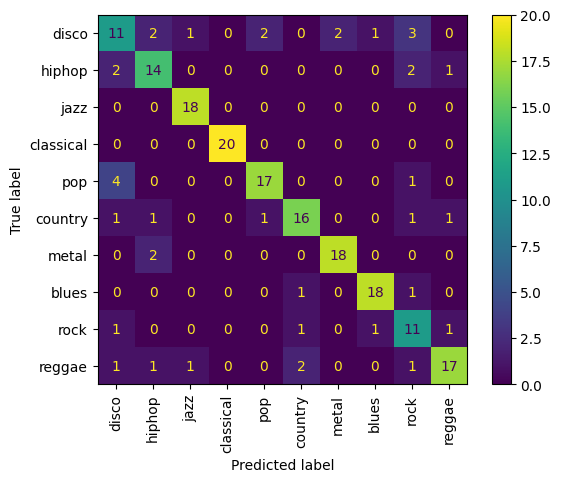

In [ ]:
cm = confusion_matrix(predictions, y_test, labels=genres)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)

disp.plot(xticks_rotation="vertical")

## Upload your song to classify

In [ ]:
uploaded = files.upload()

In [ ]:
user_songs = [song for song in uploaded.keys() if song[-3:] in ("wav", "mp3")]

In [ ]:
def predict_class(prediction):
   label_counts = Counter(prediction)
   pred = label_counts.most_common(2)

   if pred[0][1] * 0.8 < pred[1][1]:
    return ", ".join(genre[0] for genre in pred)

   return pred[0][0]

In [ ]:
for song in user_songs:
  sample, sample_rate = librosa.load(song)

  sample = librosa.feature.mfcc(y=sample, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)

  processed = sample.T @ V_T.T / S

  prediction = clf.predict(processed)
  genre_predicted = predict_class(prediction)

  print(f"{song} has genre {genre_predicted}")

Ray Charles - Hit The Road Jack.mp3 has genre reggae
Spring 1 - Vivaldi's Four Seasons.mp3 has genre classical, jazz
The Shadows - Man of Mystery.mp3 has genre country, rock
Zwyntar - Човен.mp3 has genre country
